# Kobe Bryant Shot Selection

## Import custom R modules

In [1]:
source('R/utils/devdependencies.R');
source('R/pre-processing/preprocessing.R');
source('R/pre-processing/datavis.R');

## Install dependencies

In [2]:
install_dependencies();

[1] "Installing Project dependencies/libraries... Please wait"


Installing package into 'C:/Users/Heitor/Documents/R/win-library/3.3'
(as 'lib' is unspecified)


package 'GGally' successfully unpacked and MD5 sums checked

The downloaded binary packages are in
	C:\Users\Heitor\AppData\Local\Temp\RtmpYFgcOu\downloaded_packages
[1] "Status: Success"


In [3]:
# Loading libraries
library(ggplot2)
library(GGally)

## Read the data into memory

In [4]:
# Get the csv file from the zip file
raw_data <- read.table(unz("data/rawdata_csv.zip", "data.csv"), header=T, quote="\"", sep=",");

# Print the head of the dataframe to understand the data structure
head(raw_data)

action_type,combined_shot_type,game_event_id,game_id,lat,loc_x,loc_y,lon,minutes_remaining,period,...,shot_type,shot_zone_area,shot_zone_basic,shot_zone_range,team_id,team_name,game_date,matchup,opponent,shot_id
Jump Shot,Jump Shot,10,20000012,33.9723,167,72,-118.1028,10,1,...,2PT Field Goal,Right Side(R),Mid-Range,16-24 ft.,1610612747,Los Angeles Lakers,2000-10-31,LAL @ POR,POR,1
Jump Shot,Jump Shot,12,20000012,34.0443,-157,0,-118.4268,10,1,...,2PT Field Goal,Left Side(L),Mid-Range,8-16 ft.,1610612747,Los Angeles Lakers,2000-10-31,LAL @ POR,POR,2
Jump Shot,Jump Shot,35,20000012,33.9093,-101,135,-118.3708,7,1,...,2PT Field Goal,Left Side Center(LC),Mid-Range,16-24 ft.,1610612747,Los Angeles Lakers,2000-10-31,LAL @ POR,POR,3
Jump Shot,Jump Shot,43,20000012,33.8693,138,175,-118.1318,6,1,...,2PT Field Goal,Right Side Center(RC),Mid-Range,16-24 ft.,1610612747,Los Angeles Lakers,2000-10-31,LAL @ POR,POR,4
Driving Dunk Shot,Dunk,155,20000012,34.0443,0,0,-118.2698,6,2,...,2PT Field Goal,Center(C),Restricted Area,Less Than 8 ft.,1610612747,Los Angeles Lakers,2000-10-31,LAL @ POR,POR,5
Jump Shot,Jump Shot,244,20000012,34.0553,-145,-11,-118.4148,9,3,...,2PT Field Goal,Left Side(L),Mid-Range,8-16 ft.,1610612747,Los Angeles Lakers,2000-10-31,LAL @ POR,POR,6


## Understanding the variables

In [5]:
colnames(raw_data)

[1] "action_type"        "combined_shot_type" "game_event_id"     
 [4] "game_id"            "lat"                "loc_x"             
 [7] "loc_y"              "lon"                "minutes_remaining" 
[10] "period"             "playoffs"           "season"            
[13] "seconds_remaining"  "shot_distance"      "shot_made_flag"    
[16] "shot_type"          "shot_zone_area"     "shot_zone_basic"   
[19] "shot_zone_range"    "team_id"            "team_name"         
[22] "game_date"          "matchup"            "opponent"          
[25] "shot_id"

## Separing data from submission samples

In [6]:
dataframe <- na.omit(raw_data)
submission_sample <- raw_data[is.na(raw_data$shot_made_flag),]

## Statistical Analysis (Descriptive statistics)

In [7]:
# Pick the numeric variables only
numeric_columns <- dataframe[,sapply(dataframe, class) != 'factor']
summary(numeric_columns)

 game_event_id      game_id              lat            loc_x         
 Min.   :  2.0   Min.   :20000012   Min.   :33.25   Min.   :-250.000  
 1st Qu.:111.0   1st Qu.:20500064   1st Qu.:33.88   1st Qu.: -67.000  
 Median :253.0   Median :20900337   Median :33.97   Median :   0.000  
 Mean   :249.3   Mean   :24741091   Mean   :33.95   Mean   :   7.148  
 3rd Qu.:367.0   3rd Qu.:29600270   3rd Qu.:34.04   3rd Qu.:  94.000  
 Max.   :653.0   Max.   :49900088   Max.   :34.09   Max.   : 248.000  
     loc_y             lon         minutes_remaining     period     
 Min.   :-44.00   Min.   :-118.5   Min.   : 0.000    Min.   :1.000  
 1st Qu.:  4.00   1st Qu.:-118.3   1st Qu.: 2.000    1st Qu.:1.000  
 Median : 74.00   Median :-118.3   Median : 5.000    Median :3.000  
 Mean   : 91.26   Mean   :-118.3   Mean   : 4.887    Mean   :2.521  
 3rd Qu.:160.00   3rd Qu.:-118.2   3rd Qu.: 8.000    3rd Qu.:3.000  
 Max.   :791.00   Max.   :-118.0   Max.   :11.000    Max.   :7.000  
    playoffs      se

In [8]:
categorical_columns <- dataframe[,sapply(dataframe, class) == 'factor']
summary(categorical_columns)

               action_type    combined_shot_type     season     
 Jump Shot           :15836   Bank Shot:  120    2005-06: 1924  
 Layup Shot          : 2154   Dunk     : 1056    2002-03: 1852  
 Driving Layup Shot  : 1628   Hook Shot:  127    2008-09: 1851  
 Turnaround Jump Shot:  891   Jump Shot:19710    2007-08: 1819  
 Fadeaway Jump Shot  :  872   Layup    : 4532    2009-10: 1772  
 Running Jump Shot   :  779   Tip Shot :  152    2001-02: 1708  
 (Other)             : 3537                      (Other):14771  
          shot_type                   shot_zone_area 
 2PT Field Goal:20285   Back Court(BC)       :   72  
 3PT Field Goal: 5412   Center(C)            :11289  
                        Left Side Center(LC) : 3364  
                        Left Side(L)         : 3132  
                        Right Side Center(RC): 3981  
                        Right Side(R)        : 3859  
                                                     
              shot_zone_basic         shot_zone_

## Data visualization

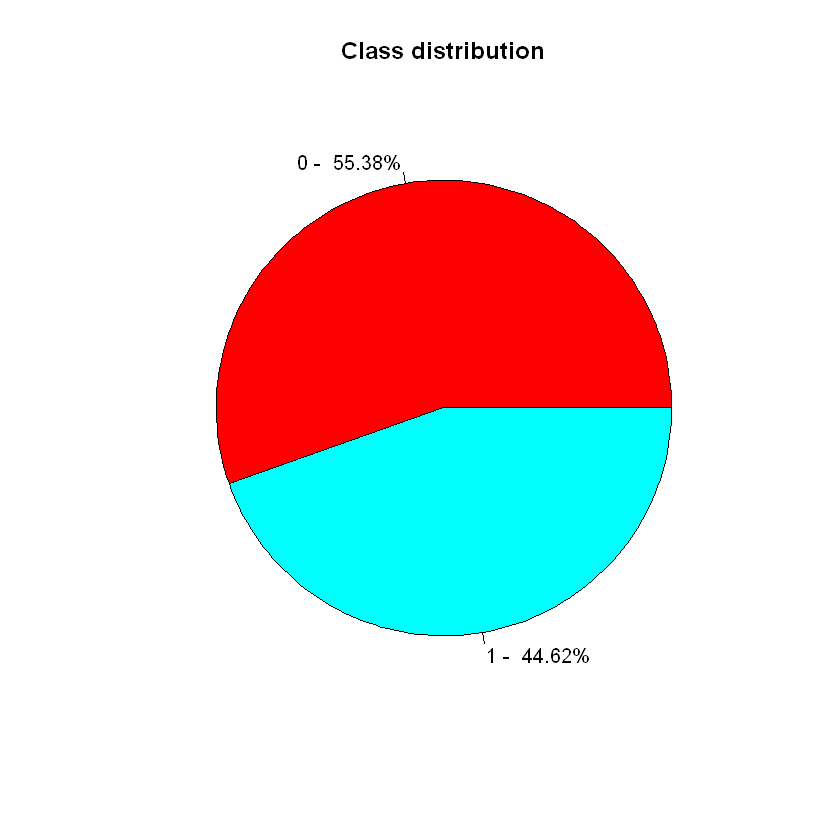

In [9]:
# Class distribution
prop <- c(sum(dataframe$shot_made_flag == 0), sum(dataframe$shot_made_flag == 1))/nrow(dataframe)
lbls <- c("0 - ", "1 - ")
lbls <- paste(lbls, format(round(prop*100, 2), nsmall = 2))
lbls <- paste(lbls, "%", sep="")
#options(repr.plot.width=4, repr.plot.height=4)
pie(prop, labels=lbls, col=rainbow(length(lbls)), main="Class distribution")

### Spatial variables

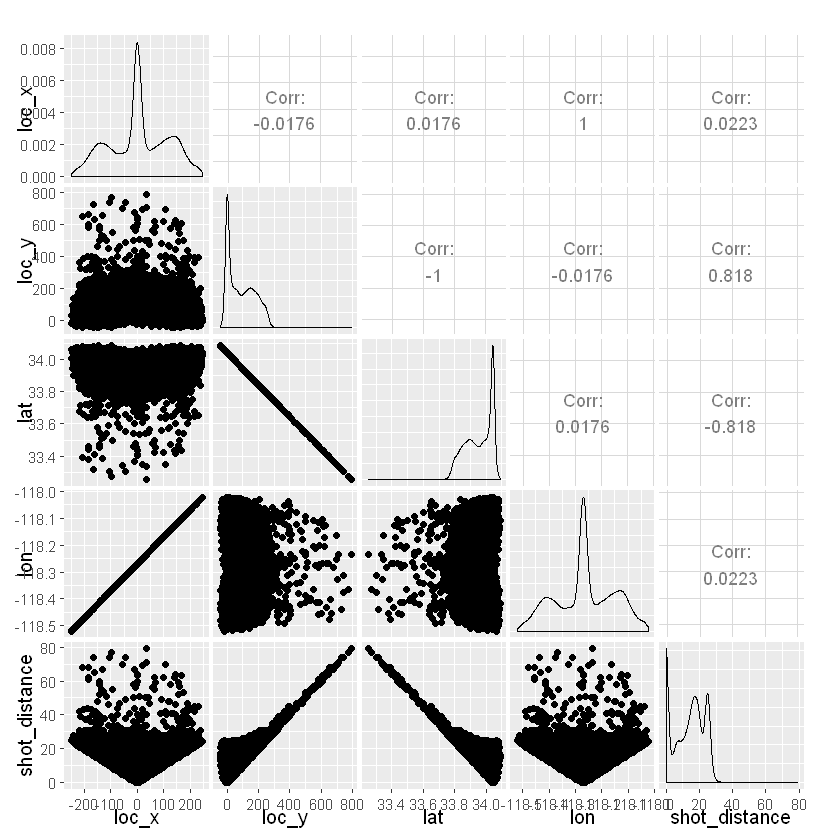

In [12]:
# Quartiles and scatter matrix of 'loc_x', 'loc_y', 'lat', 'lon', 'shot_distance'
pm <- ggpairs(dataframe, columns = c('loc_x', 'loc_y', 'lat', 'lon', 'shot_distance'))
pm

### Correlation Matrix

In [11]:
# Print and save the correlation matrix